<a href="https://colab.research.google.com/github/dipit099/Deep_Learning-Colab/blob/main/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/titanic/train.csv')

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
data.shape


(891, 12)

In [12]:
data.describe()

,PassengerId,Survived,Pclass,Age,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,32.204208
std,257.353842,0.486592,0.836071,14.526497,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,512.329200


In [8]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

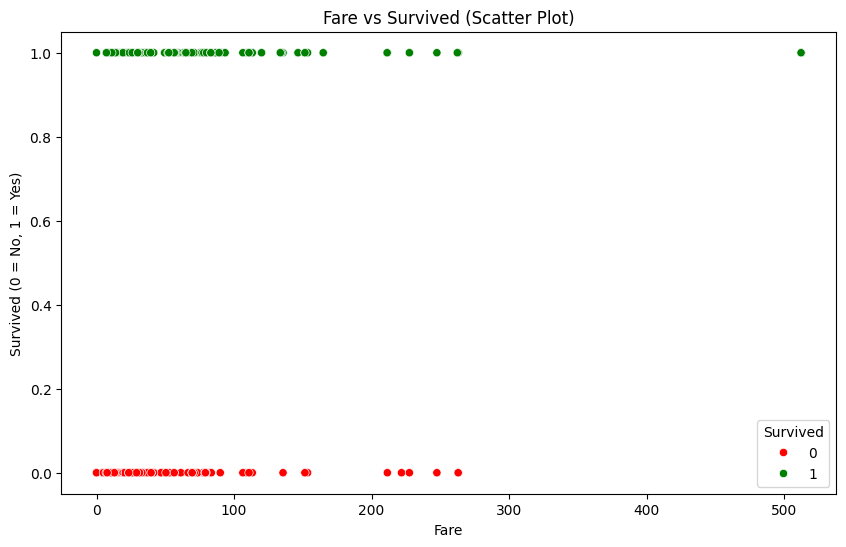

In [9]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(x='Fare', y='Survived', data=data, hue='Survived', palette={0: 'red', 1: 'green'})

# Set the title and labels
plt.title('Fare vs Survived (Scatter Plot)')
plt.xlabel('Fare')
plt.ylabel('Survived (0 = No, 1 = Yes)')

# Show the plot
plt.show()


In [11]:
data = data.drop(['Name', 'Parch', 'SibSp'], axis=1)

In [13]:
object_columns = data.select_dtypes(include='object').columns
print(object_columns)

Index(['Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


In [19]:
unique_sex = data['Embarked_encoded'].unique()
print(unique_sex)

[2 0 1 3]


In [15]:
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Sex_encoded'] = le.fit_transform(data['Sex'])
data['Embarked_encoded'] = le.fit_transform(data['Embarked'])

data.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Sex_encoded,Embarked_encoded
0,1,0,3,male,22.0,A/5 21171,7.2500,NaN,S,1,2
1,2,1,1,female,38.0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,0,2
3,4,1,1,female,35.0,113803,53.1000,C123,S,0,2
4,5,0,3,male,35.0,373450,8.0500,NaN,S,1,2
